In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sampling import NestedSampling, Uniform, Callback

In [2]:
s = pd.HDFStore('clemb_output.h5')
df = s['df']
s.close()

In [3]:
from clemb.forward_model import forward_model, fullness, esol

class PyCallback(Callback):
    
    def __init__(self, t0, t1, t_std, melt, 
                 vol, a, solar, dt):
        Callback.__init__(self)
        self.t0 = t0
        self.t1 = t1
        self.melt = melt
        self.vol = vol
        self.a = a
        self.solar = solar
        self.dt = dt
        self.t_std = t_std
        
    def set_data(self, t0, t1, t_std, melt,
                 vol, a, solar, dt):
        self.t0 = t0
        self.t1 = t1
        self.melt = melt
        self.vol = vol
        self.a = a
        self.solar = solar
        self.dt = dt
        self.t_std = t_std

    def run(self, vals):
        h = vals[0]*0.0864
        m = vals[1]
        t_s = forward_model(self.t0, self.dt, h, 
                            m, self.vol, self.a,
                            self.solar)
        lh = 1./(np.sqrt(2.*np.pi)*self.t_std)*np.exp(-1./(2.*self.t_std**2)*(t_s-self.t1)**2)
        return np.log(lh)

hmin = 0.
hmax = 800.
h = Uniform('h', hmin, hmax)
m = Uniform('m', 0, 20)
ns = NestedSampling()

<IPython.core.display.Javascript object>


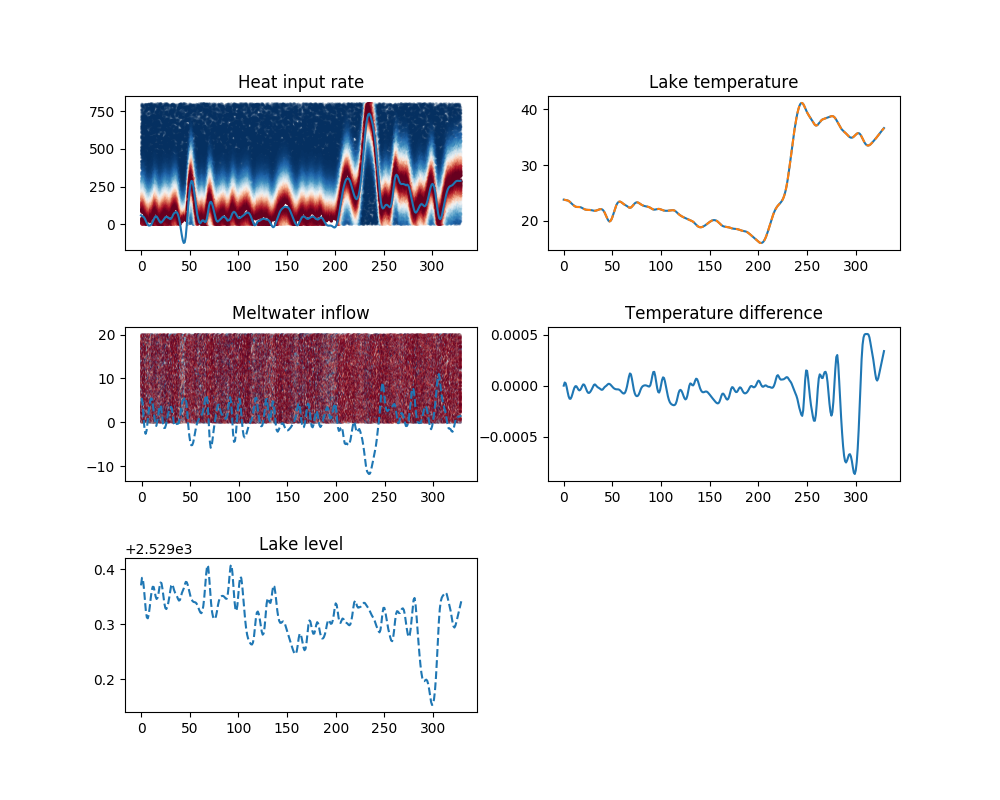

In [5]:
startdate = '2017-01-01'
pwr = df.loc[0,'pwr']*0.0864
pwr = pwr.loc[pwr.index > startdate]
datetime = pwr.index

melt = df.loc[0,'fmelt']
melt = melt.loc[melt.index > startdate]

ll = df.loc[0,'llvl']
ll = ll.loc[ll.index > startdate]

t = df.loc[0,'t']
t = t.loc[t.index > startdate]

ndays = (datetime[-1] - datetime[0]).days
dt = 1.
nsteps = int(ndays/float(dt))
time = np.linspace(0,ndays,nsteps+1)
T0 = t.values[0]
y = np.zeros(nsteps+1)
nsamples = 300
pwr_samples = np.zeros((y.size, nsamples))
m_samples = np.zeros((y.size, nsamples))
lh = np.zeros((y.size, nsamples))
y[0] = T0

pycb = PyCallback(0.,0.,0.,0.,0.,0.,0.,0.)
pycb.__disown__()
ns.setCallback(pycb)

for i in range(nsteps):
    a, vol = fullness(ll.values[i+1])
    solar = esol(i*dt, a, datetime)
    # Take samples from the input
    pwr_sigma = 20
    t_sigma = 0.3
    
    if False:
        samples = pwr_sigma*np.random.randn(nsamples)+pwr.values[i+1]
        for j,s in enumerate(samples):
            y_s = forward_model(y[i], dt, s, melt.values[i+1],
                                vol, a, solar)
            lh_s = 1./(np.sqrt(2.*np.pi)*t_sigma)*np.exp(-1./(2.*t_sigma**2)*(y_s-t.values[i+1])**2)
            pwr_samples[i, j] = s/0.0864
            lh[i, j] = lh_s
    
    if True:
        pycb.set_data(y[i], t.values[i+1], t_sigma,
                      melt.values[i+1], vol, a, solar, dt)
        rs = ns.explore(vars=[h, m], initial_samples=100,
                        maximum_steps=nsamples)
        smp = rs.get_samples()
        for j,_s in enumerate(smp):
            pwr_samples[i, j] = _s._vars[0].get_value()
            m_samples[i, j] = _s._vars[1].get_value()
            lh[i, j] = np.exp(_s._logL)
    
    y[i+1] = forward_model(y[i], dt, pwr.values[i+1], melt.values[i+1],
                           vol, a, solar)
                       
mpl.rcParams['figure.subplot.hspace'] = 0.5
plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,2,1)
ax1.plot(time, pwr.values/0.0864)
for k in range(nsteps):
    ax1.scatter(np.ones(nsamples)*k+1, pwr_samples[k], s=2, c=lh[k],
                cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)

ax1.set_title('Heat input rate')

ax2 = plt.subplot(3,2,3)
ax2.plot(time, melt.values, ls='--')
for k in range(nsteps):
    ax2.scatter(np.ones(nsamples)*k, m_samples[k], s=2, c=lh[k],
                cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)

ax2.set_title('Meltwater inflow')

ax3 = plt.subplot(3,2,5)
ax3.plot(time, ll.values[:], ls='--')
ax3.set_title('Lake level')

ax4 = plt.subplot(3,2,2)
ax4.plot(time, y)
ax4.plot(time, t.values[:], ls='--')
ax4.set_title('Lake temperature')

ax5 = plt.subplot(3,2,4)
ax5.plot(time, t.values[:]-y)
ax5.set_title('Temperature difference')

In [15]:
pwr_samples[0]

array([ 784.6384691 ,  773.36865197,  768.84089622,  767.67699376,
        751.62527459,  749.20399206,  742.89394137,  740.97015165,
        715.65230122,  713.36306942,  709.17654175,  703.09175885,
        698.65304513,  678.40161419,  667.56328837,  665.27706617,
        649.68667064,  646.0641356 ,  629.91927441,  596.71424138,
        588.28800922,  587.03521468,  579.70524599,  579.43384133,
        561.10491198,  560.06758586,  559.25187409,  547.11782267,
        543.39013674,  528.19910206,  526.45990597,  524.83219405,
        518.11180708,  514.65862274,  514.5276576 ,  513.33561757,
        510.22421587,  503.2628092 ,  501.38895106,  496.23355944,
        495.58634883,  491.23003623,  491.11488716,  485.58072859,
        481.46974239,  481.31955231,  468.55634763,  468.14270362,
        447.65332808,  446.36660645,  446.01577645,  441.68323434,
        439.7877006 ,  434.55267438,  427.78872572,  420.86871105,
        413.85377688,  409.95875684,  409.10256248,  402.93052

### using scipy.ode package

In [1]:
from scipy.integrate import solve_ivp
def fun(time, state):
    cw = 0.0042
    ws = 4.5
    density = 1.003 - 0.00033 * state[3]
    a, vol = fullness(state[2])
    enth = 6.
    mass = vol*density
    qe, me = es(state[3], ws, a)
    factor = state[3]*cw/(enth - state[3]*cw)
    mi = state[0]/(enth - cw*state[3]) + state[1]*factor
    ms = state[1]
    mout = state[1] - me
    mout=0.
    g0 = fun.dmi(round(time, 4))
    g1 = fun.dms(round(time, 4))
    g2 = fun.dll(round(time,4))
    g3 = 1./(cw*mass)*(-qe + esol(time, a, fun.datetime)  + state[0]*0.0864 -cw*state[3]*mout -cw*state[1]*state[3])
    return np.array([g0, g1, g2, g3])

startdate = '2017-07-15'
pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > startdate]
datetime = pwr.index
pwr_grad = np.gradient(pwr)
time_orig = np.arange(pwr.index.size)
f_mi = interp1d(time_orig, pwr_grad)

melt = df.loc[0,'fmelt']
melt = melt.loc[melt.index > startdate]
melt_grad = np.gradient(melt)
f_ms = interp1d(time_orig, melt_grad)

ll = df.loc[0,'llvl']
ll = ll.loc[ll.index > startdate]
ll_grad = np.gradient(ll)
f_ll = interp1d(time_orig, ll_grad)

t = df.loc[0,'t']
t = t.loc[t.index > startdate]

ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time = np.linspace(0,ndays,nsteps+1)

Mi0 = pwr.values[0]
Ms0 = melt.values[0]
Ll0 = ll.values[0]
T0 = t.values[0]
y0 = [Mi0, Ms0, Ll0, T0]

fun.datetime = datetime
fun.dmi = f_mi
fun.dms = f_ms
fun.dll = f_ll
sol = solve_ivp(fun, [time[0], time[-1]], y0, t_eval=time)
plt.figure()
plt.plot(time_orig, error(sol.y[3,:], t.values[:], sol.t, time_orig))

NameError: name 'df' is not defined

### Unscented Kalman Filter

In [229]:
def dT_ca(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = state[3]
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    g3 = 0.
    return np.array([g0, g1, g2, g3])

def dT_cv(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    #g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864 -cw*state[2]*mout)
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1, g2])

def fx_ca(x, dt):
    x_new = rk4(x, time, dt, dT_ca, datetime=fx_ca.datetime)
    x_new[0] += 0.5*dt*dt*x[3]
    return x_new

def fx_cv(x, dt):
    x_new = rk4(x, time, dt, dT_cv, datetime=fx_cv.datetime)
    return x_new

def hx(x):
    return x[2]

In [230]:
def df_resample(df):
    """
    Resample dataframe to daily sample rate.
    """
    # First upsample to 15 min intervals combined with a linear interpolation
    ndates = pd.date_range(start=df.index.date[0], end=df.index.date[-1],freq='15T')
    ndf = df.reindex(ndates,method='nearest',tolerance=np.timedelta64(15,'m')).interpolate()
    # Then downsample to 1 day intervals assigning the new values to mid day
    ndf = ndf.resample('1D',label='left').mean()
    return ndf

In [231]:
base_url = "https://fits.geonet.org.nz/observation"
url = "{}?siteID=RU001&networkID=VO&typeID=t&methodID={}"
names = ['t', 't_err']
tdf1 = pd.read_csv(url.format(base_url, 'therm'),index_col=0, names=names, skiprows=1,
                   parse_dates=True)
tdf2 = pd.read_csv(url.format(base_url, 'thermcoup'),index_col=0, names=names, skiprows=1,
                              parse_dates=True)
tdf3 = pd.read_csv(url.format(base_url, 'logic'),index_col=0, names=names, skiprows=1,
                              parse_dates=True)
tdf3 = tdf3.combine_first(tdf2)
tdf3 = tdf3.combine_first(tdf1)
tdf = df_resample(tdf3)
t = tdf.loc[(tdf.index > '2017-01-15')&(tdf.index < '2017-10-13')]
t = t['t']

In [232]:
from __future__ import (absolute_import, division)
from filterpy.common import dot3
import numpy as np
from numpy import dot, zeros


class IMMEstimator(object):
    """ Implements an Interacting Multiple-Model (IMM) estimator.
    References
    ----------
    Bar-Shalom, Y., Li, X-R., and Kirubarajan, T. "Estimation with
    Application to Tracking and Navigation". Wiley-Interscience, 2001.
    Crassidis, J and Junkins, J. "Optimal Estimation of
    Dynamic Systems". CRC Press, second edition. 2012.
    Labbe, R. "Kalman and Bayesian Filters in Python".
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
    """

    def __init__(self, filters, mu, M):
        """"
        Parameters
        ----------
        filters : (N,) array_like of KalmanFilter objects
            List of N filters. filters[i] is the ith Kalman filter in the
            IMM estimator.
        mu : (N,) ndarray of float
            mode probability: mu[i] is the probability that
            filter i is the correct one.
        M : (N,N) ndarray of float
            Markov chain transition matrix. M[i,j] is the probability of
            switching from filter j to filter i.
        """

        assert len(filters) > 1

        self.filters = filters
        self.mu = mu
        self.M = M

        # compute # random variables in the state
        x_shape = (3,)
        n_states = 3
        self.x = np.zeros(x_shape)
        self.P = np.zeros((n_states, n_states))

        self.N = len(filters) # number of filters


    def update(self, z, u=None):
        """
        Add a new measurement (z) to the Kalman filter. If z is None, nothing
        is changed.
        Parameters
        ----------
        z : np.array
            measurement for this update.
        u : np.array, optional
            u[i] contains the control input for the ith filter
        """

        # run update on each filter, and save the likelihood in L
        L = zeros(len(self.filters))
        for i, f in enumerate(self.filters):
            f.predict()
            f.update(z)
            L[i] = f.likelihood

        # initial condition IMM state, covariance
        xs, Ps = [], []
        # each element j = sum M_ij * mu_i
        
        # cbar is the total probability, after interaction, 
        # that the target is in state j. We use it as the
        # normalization constant.
        self.cbar = dot(self.mu, self.M) 

        # compute mixing probabilities
        omega = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                omega[i, j] = (self.M[i, j] * self.mu[i]) / self.cbar[j]

        # compute mixed initial conditions
        for i, (f, w) in enumerate(zip(self.filters, omega.T)):
            x = np.zeros(3)
            for kf, wj in zip(self.filters, w):
                x += kf.x[0:3] * wj
            xs.append(x)
            

            P = np.zeros((3,3))
            for kf, wj in zip(self.filters, w):
                y = kf.x[0:3] - x
                P += wj * (np.outer(y, y) + kf.P[0:3,0:3])
            Ps.append(P)
            

        # perform predict step using the mixed initial conditions
        for i, f in enumerate(self.filters):
            # propagate using the mixed state estimate and covariance
            f.x[0:3] = xs[i]
            f.P[0:3,0:3] = Ps[i]
            f.predict()

        # compute mixed IMM state and covariance
        self.x.fill(0.)
        self.P.fill(0.)

        for f, w in zip(self.filters, self.mu):
            self.x += f.x[0:3] * w

        for f, w in zip(self.filters, self.mu):
            y = f.x[0:3] - self.x
            self.P += w * (np.outer(y, y) + f.P[0:3,0:3])

        # update mode probabilities from total probability * likelihood
        self.mu =  self.cbar * L
        self.mu /= sum(self.mu) # normalize

<IPython.core.display.Javascript object>


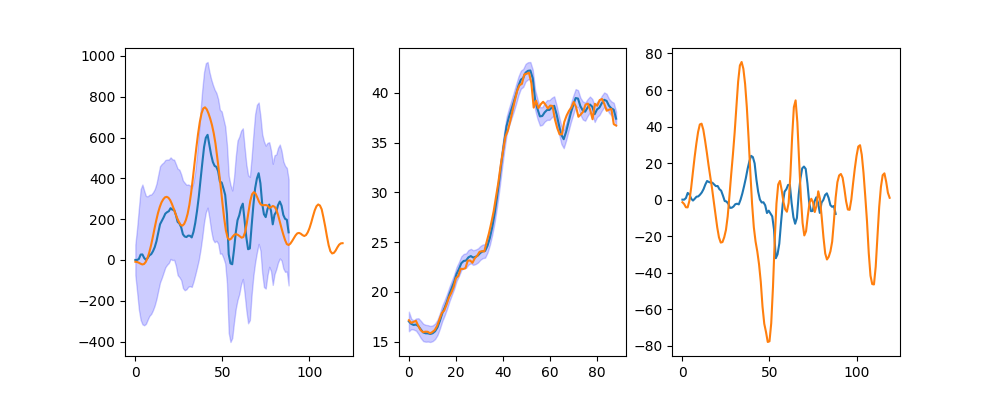

In [235]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import copy

pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > '2017-07-15']
datetime = pwr.index
pwr_grad = np.gradient(pwr)
time_orig = np.arange(pwr.index.size)

#t = df.loc[0,'t']
t = t.loc[t.index > '2017-07-15']
datetime = t.index
tt = np.arange(t.index.size)



ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time_new = np.linspace(0,ndays,nsteps)
To = t.values[0]
Qio = 0
dQio = 0
aQio = 0.

fx_ca.datetime = datetime
points = MerweScaledSigmaPoints(n=4, alpha=.5, beta=2., kappa=-1.)
kf_ca = UKF(4, 1, dt, fx=fx_ca, hx=hx, points=points)
kf_ca.P = np.eye(4)*10
kf_ca.x = np.array([Qio, dQio, To, aQio])
kf_ca.R = np.array([.0001])
a = Q_discrete_white_noise(3, dt=dt, var=100.)
b = np.insert(a, 2, 0., axis=1)
kf_ca.Q = np.insert(b, 2, [0., 0., 0.01, 0.], axis=0)
kf_ca.Q = np.array([[3, 0.1, 0., 0.1], [0.1, 3, 0, 0.1], [0., 0., 0.01, 0.], [0.1, 0.1, 0., 100]])

fx_cv.datetime = datetime
points = MerweScaledSigmaPoints(n=3, alpha=.5, beta=2., kappa=0.)
kf_cv = UKF(3, 1, dt, fx=fx_cv, hx=hx, points=points)
kf_cv.P = np.eye(3)*100
kf_cv.x = np.array([Qio, dQio, To])
kf_cv.R = np.array([1.])
kf_cv.Q = np.eye(3)
kf_cv.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=1.)
kf_cv.Q[2,2] = 0.01

kf_ca1 = copy.deepcopy(kf_ca)
kf_ca1.Q = np.eye(4)
kf_ca1.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf_ca1.Q[2,2] = 0.01
kf_ca1.Q[3,3] = 0.
kf_ca1.x = np.array([Qio, dQio, To, aQio])

kf_cv1 = copy.deepcopy(kf_cv)
kf_cv1.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=100.)

res_mean = []
res_cov = []

filters = [kf_cv1, kf_cv]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

for i in range(nsteps):
    time = i*dt
    #kf_ca.predict()
    bank.update(t.values[i])
    res_mean.append(bank.x.copy())
    res_cov.append(bank.P.copy())
res_mean = np.array(res_mean)
res_cov = np.array(res_cov)
#(x, P, K) = kf.rts_smoother(res_mean, res_cov)
#res_mean = x
#res_cov = P

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(time_new,res_mean[:,0])
miny = res_mean[:,0] - 3*np.sqrt(res_cov[:,0,0])
maxy = res_mean[:,0] + 3*np.sqrt(res_cov[:,0,0])
plt.fill_between(time_new,miny,maxy,color='b',alpha=0.2)
plt.plot(time_orig, pwr.values)

plt.subplot(1,3,2)
plt.plot(time_new,res_mean[:,2])
miny = res_mean[:,2] - res_cov[:,2,2]
maxy = res_mean[:,2] + res_cov[:,2,2]
plt.fill_between(time_new,miny,maxy,color='b',alpha=0.2)
plt.plot(tt, t.values)
plt.subplot(1,3,3)
plt.plot(time_new,res_mean[:,1])
plt.plot(time_orig, pwr_grad)

### Particle Filter

(array([ 0.00131294,  0.00204235,  0.00233411,  0.0032094 ,  0.00175058,
         0.00029176,  0.00029176,  0.00029176,  0.00043765,  0.00102117]),
 array([ -22.07853526,   54.94231277,  131.9631608 ,  208.98400883,
         286.00485686,  363.0257049 ,  440.04655293,  517.06740096,
         594.08824899,  671.10909702,  748.12994505]),
 <a list of 10 Patch objects>)

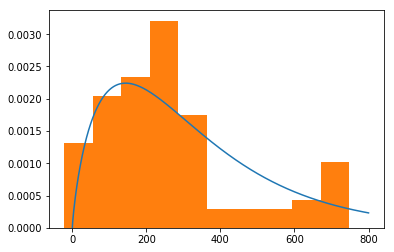

In [10]:
from scipy.stats import gamma, norm
x = np.linspace(0,800,1000)
rv = gamma(1.8,0,180)
plt.plot(x, rv.pdf(x))
plt.hist(pwr, normed=True)

(array([ 0.0036656 ,  0.00146624,  0.00146624,  0.01026369,  0.01759489,
         0.01172993,  0.00513184,  0.00733121,  0.00293248,  0.0036656 ]),
 array([-77.92418844, -62.59798441, -47.27178039, -31.94557637,
        -16.61937235,  -1.29316832,  14.0330357 ,  29.35923972,
         44.68544375,  60.01164777,  75.33785179]),
 <a list of 10 Patch objects>)

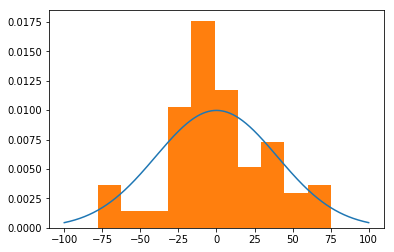

In [11]:
x = np.linspace(-100.,100.,5000)
plt.plot(x, norm(0, 40).pdf(x))
plt.hist(np.gradient(pwr), normed=True)

In [12]:
np.random.random()*0.01

0.006596587023552335

In [13]:
def create_initial_particles(N):
    T0 = np.ones(N)*t.values[0]
    Enth0 = np.ones(N)*70.
    Ms0 = np.ones(N)*1.
    particles = np.zeros((N,5))
    particles[:,0] = gamma(1., 0, 80).rvs(size=N)
    particles[:,1] = norm(0, 40).rvs(size=N)
    particles[:,2] = T0
    particles[:,3] = Enth0
    particles[:,4] = Ms0
    return particles

In [14]:
def deriv(state, time):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(state[3] - cw*state[2])
    ms = state[4]
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    g2 = 1./(cw*mass)*(-qe + esol(dt, time, a)  + state[0]*0.0864 -cw*state[2]*mout)
    g3 = 0.0
    g4 = 0.0
    return np.array([g0, g1, g2, g3, g4])

In [15]:
def predict(particles, time, dt):
    particles[:,1] += np.random.normal(scale=10.)
    for i in range(particles.shape[0]):
        particles[i,:] = rk4(particles[i,:], time, dt, deriv)
    particles[:,0] += np.random.normal(scale=2)
    particles[:,2] += np.random.normal(scale=2)
    return particles

In [16]:
def update(particles, weights, z):
    weights.fill(1.)
    weights = norm(particles[:,2], .5).pdf(z)
    weights[np.isnan(weights)] = 0.0
    idx = np.where(particles[:,0] < 0.0)
    weights[idx[0]] = 0.0
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    return weights

In [17]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    val = particles[:, 0:3]
    mean = np.average(val, weights=weights, axis=0)
    var  = np.average((val - mean)**2, weights=weights, axis=0)
    return mean, var

In [18]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [19]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill (1.0 / len(weights))
    return particles, weights

(-100, 1000)

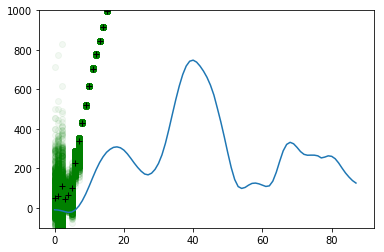

In [20]:
from filterpy.monte_carlo import systematic_resample, residual_resample
pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > '2017-07-15']
datetime = pwr.index

t = df.loc[0,'t']
t = t.loc[t.index > '2017-07-15']

ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time = np.linspace(0,ndays,nsteps+1)

npart = 1000
particles = create_initial_particles(npart)
weights = np.ones(npart)

for i in range(nsteps):
    particles = predict(particles, i*dt, dt)
    weights = update(particles, weights, t[i])
    mean, var = estimate(particles, weights)
    if neff(weights) < npart/4:
        indexes = residual_resample(weights)
        particles, weights = resample_from_index(particles, weights, indexes)

    plt.scatter(np.ones(npart)*i, particles[:,0], alpha=0.05, color='g')
    plt.plot(i, mean[0], 'k+')
plt.plot(pwr.values[:nsteps])
plt.ylim(-100,1000)

In [21]:
np.random.normal(scale=5,size=100)

array([ -1.50755937,  -2.22277362,  -7.28320236,   6.29348082,
         0.63265578,   1.62538258,  -0.93137448,  -6.61790111,
        -4.24792392,   4.42522273,  -3.65070866,  -5.52407529,
         5.06234476,   4.62315179,   7.14387697,   0.95102176,
         2.98472161,   1.56731739,  -3.47295973,   3.54570969,
        -0.53896536,  -1.33506238,   4.87314926,  -1.9310591 ,
        -1.81482029,  -2.23472232,   2.35977622,  -1.14529253,
       -12.13713411,   1.82366426,  -2.62935837,   7.39233238,
         3.90487521,  -3.17524541,  -5.97167277,  -3.84132254,
        -2.24580605,  -2.90348043,   5.64559217,  -0.78695306,
        -2.91607066,  -2.53442723,   4.61585767,   4.583517  ,
        -6.15028894,   4.53932601,  -6.74967566,  -4.49120263,
        10.04018928,  -8.45259737,  -1.88794113,  -0.05558405,
         8.67314888,   7.03474201,  -2.95832129,   3.09488881,
        -9.98767173,  -2.23360414,   5.49843186,  -7.10526508,
         0.24202535,  -6.6734059 ,  -6.26194967,   0.80

In [22]:
idx = np.argmax(weights)
particles[idx]

array([  6.06665549e+03,   9.63912209e+01,   1.21424910e+02,
         7.00000000e+01,   1.00000000e+00])

### Sigma-point particle filter

#### Model the input

In [12]:
# matplotlib.rcParams['axes.prop_cycle']
cl1 = '#1f77b4'
cl2 = '#ff7f0e'
cl3 = '#2ca02c'

In [19]:
def dT1(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[1]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    mass = vol*density
    qe, me = es(state[1], w, a)
    g0 = 300*np.cos(2.*np.pi*0.02*time + np.deg2rad(45))*2.*np.pi*0.02
    g1 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1])


<IPython.core.display.Javascript object>


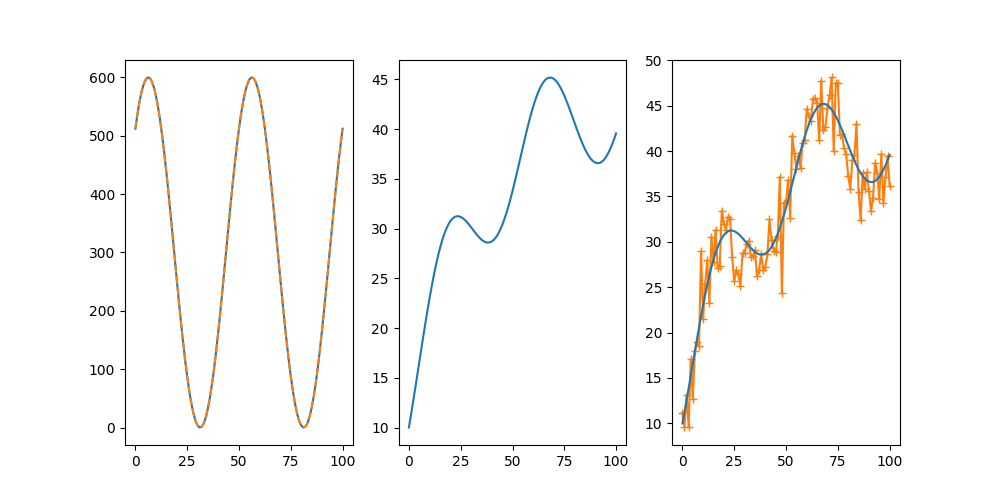

In [20]:
f = 0.02
nsteps = 101
t = np.linspace(0, 100, nsteps)
dt = 1.0
qi = np.sin(2.*np.pi*f*t + np.deg2rad(45))*300.+300.
datetime = pd.date_range('1/1/2017', periods=102, freq='D')
y = np.zeros((nsteps, 2))
y[0] = [qi[0], 10.]
for i in range(nsteps-1):
    y[i+1] = rk4(y[i], i*dt, dt, dT1, datetime=datetime)

np.random.seed(12)
T_obs = y[:,1] + np.random.randn(nsteps)*2.5
T_true = y[:,1]
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t,qi)
plt.plot(t, y[:,0], ls='--')
plt.subplot(1,3,2)
plt.plot(t, y[:,1])
plt.subplot(1,3,3)
plt.plot(t, T_obs, marker='+', color=cl2)
plt.plot(t, y[:,1], color=cl1)

<IPython.core.display.Javascript object>


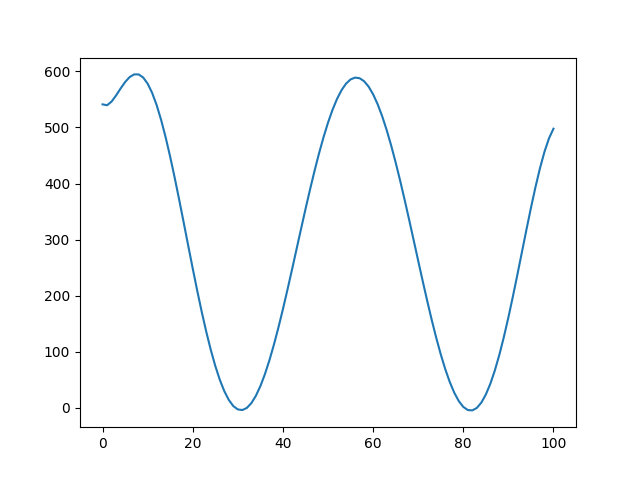

In [29]:
# Polynomial fit
p = np.poly1d(np.polyfit(t, y[:,0],8))
#y_fit = p[0]*t**3 + p[1]*t**2 + p[2]**t +p[3]
plt.figure()
plt.plot(t, p(t))

#### Now try to recover the input

In [242]:
def dT_cv(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    #g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864 -cw*state[2]*mout)
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1, g2])

def fx_cv(x, dt, time):
    x_new = rk4(x, time, dt, dT_cv, datetime=fx_cv.datetime)
    return x_new

def hx(x):
    return x[2]

#### First try the standard Unscented Kalman filter

<IPython.core.display.Javascript object>


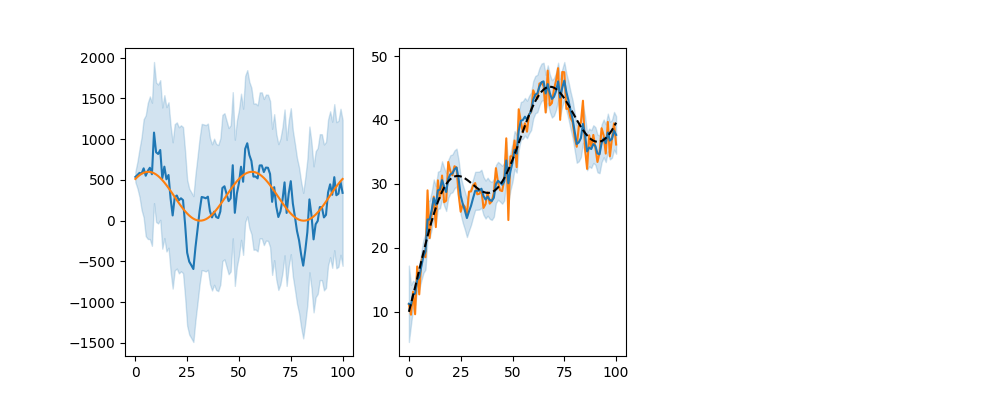

In [247]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise


fx_cv.datetime = datetime
points = MerweScaledSigmaPoints(n=3, alpha=.5, beta=2., kappa=0.)
kf_cv = UKF(3, 1, dt, fx=fx_cv, hx=hx, points=points)
kf_cv.P = np.eye(3)*100
kf_cv.x = np.array([qi[0], qi[1] - qi[0], T_obs[0]])
kf_cv.R = np.array([6.25])
kf_cv.Q = np.eye(3)
kf_cv.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=1000.)
kf_cv.Q[2,2] = .1

res_mean = []
res_cov = []
for i in range(nsteps):
    kf_cv.predict(fx_args=(i*dt))
    kf_cv.update(T_obs[i])
    res_mean.append(kf_cv.x.copy())
    res_cov.append(kf_cv.P.copy())
res_mean = np.array(res_mean)
res_cov = np.array(res_cov)

time = t
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(time,res_mean[:,0], color=cl1)
miny = res_mean[:,0] - 3*np.sqrt(res_cov[:,0,0])
maxy = res_mean[:,0] + 3*np.sqrt(res_cov[:,0,0])
plt.fill_between(time,miny,maxy,color=cl1,alpha=0.2)
plt.plot(time, qi, color=cl2)

plt.subplot(1,3,2)
plt.plot(time, T_obs, color=cl2)
plt.plot(time,res_mean[:,2], color=cl1)
miny = res_mean[:,2] - res_cov[:,2,2]
maxy = res_mean[:,2] + res_cov[:,2,2]
plt.fill_between(time,miny,maxy,color=cl1,alpha=0.2)
plt.plot(time, T_true, color='k', ls='--')


'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


In [ ]:
ax.col